<a href="https://colab.research.google.com/github/Robotmurlock/MATF-AZRS/blob/main/01-pix2pix/mnist-long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Tuple
from dataclasses import dataclass
from datetime import datetime
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from PIL import Image
from IPython import display

In [ ]:
# Parametri okruzenja
MASTER_FOLDER = 'pix2pix' # Folder gde se cuvaju svi rezultati
BATCH_SIZE = 40 
IMG_SIZE = 32 # Pozeljno je da dimenzija slike bude stepen dvojke zbog U-NET modela
IMG_CHANNELS = 1
SKUP_PODATAKA = 'mnist' # 'fashion_mnist'

In [ ]:
# Ucitavanje MNIST skupa podataka
(tf_train, tf_test), ds_info = tfds.load(
    SKUP_PODATAKA,
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=False,
    with_info=True,
)

# Obrada podataka
def create_mnist_input(img, radius=4):
  """
  Posto su tenzori imutabilni (Osim ako se ne koristi Variable), u ovom slucaju se slika deli na 5 delova u odnosu na deo slike koji se brise
  1. Deo slike koji se brise tj. postavlja se sivi kvadrat
  2. Deo slike levo od kvadrata
  3. Deo slike desno od kvadrata
  4. Deo slike iznad kvadrata
  5. Deo slike ispod kvadrata
  2 2 2 4 4 3
  2 2 2 4 4 3
  2 2 2 4 4 3
  2 2 2 1 1 3
  2 2 2 1 1 3
  2 2 2 4 4 3

  Kvadrat se ne postavlja na ivicama kako bi zadatak bio nesto tezi 
  (model bi lako naucio da ivice uvek popuni crnom bojom jer se tu ne nalaze brojevi).

  Alternativa bi bila da se podaci pretprocesiraju koriscenjem numpy.

  :param img: Slika
  :param radius: Radijus kvadrata, polovina stranice
  :return: Slika sa kvadratom
  """
  img_input = tf.identity(img)
  x_coord = np.random.randint(max(radius, 8), min(IMG_SIZE-8, IMG_SIZE-radius))
  y_coord = np.random.randint(max(radius, 8), min(IMG_SIZE-8, IMG_SIZE-radius))
  
  img_input_left = img_input[:x_coord-radius, :, :]
  img_input_right = img_input[x_coord+radius:, :, :]
  img_input_top = img_input[x_coord-radius:x_coord+radius, :y_coord-radius, :]
  img_input_bottom = img_input[x_coord-radius:x_coord+radius, y_coord+radius:, :]
  img_input_center = tf.ones(shape=(2*radius, 2*radius, 1)) * 64
  img_input_bottom_center_top = tf.concat([img_input_top, img_input_center, img_input_bottom], axis=1)
  img_input = tf.concat([img_input_left, img_input_bottom_center_top, img_input_right], axis=0)

  return img_input, img

def tf_pipeline(tf_dataset):
  rotation = layers.RandomRotation(factor=(-0.1, 0.1))
  flip = tf.keras.layers.RandomFlip()

  # Konvertovanje ulaza u sliku dimenzije 32x32
  tf_dataset = tf_dataset.map(lambda x: tf.cast(x['image'], tf.float32))
  tf_dataset = tf_dataset.map(lambda x: tf.image.resize(x, (IMG_SIZE, IMG_SIZE), method='nearest'))

  # Neophodno je da postoji neka vrsta suma
  tf_dataset = tf_dataset.map(lambda x: rotation(x)) 
  tf_dataset = tf_dataset.map(lambda x: x if np.random.random() <= 0.5 else flip(x)) 

  # Dodavanje nasumicne "beline" na sliku
  tf_dataset = tf_dataset.map(create_mnist_input)

  # Pikseli sa normalizuju na interval [0, 1]
  tf_dataset = tf_dataset.map(lambda x, y: (x / 255.0, y / 255.0)) 
  tf_dataset = tf_dataset.shuffle(100)
  tf_dataset = tf_dataset.batch(BATCH_SIZE)
  return tf_dataset

tf_train = tf_pipeline(tf_train)
tf_test = tf_pipeline(tf_test)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Pomocna funkcija za prikazivanja slika
def show_image(img: tf.Tensor, title=None) -> None:
  fig, ax = plt.subplots(figsize=(6, 4))
  ax.imshow(tf.reshape(img, shape=(IMG_SIZE, IMG_SIZE)), cmap='gray')
  ax.axis('off')
  ax.set_title(title)
  plt.show()

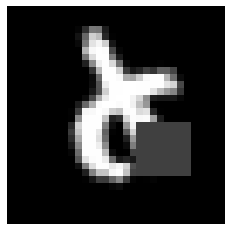

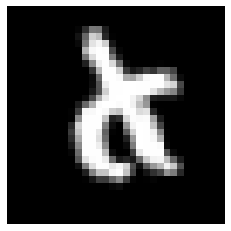

In [ ]:
# Provera obradjenog skupa podataka
for x, y in tf_train.take(1):
  assert x.shape == (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1)
  show_image(x[4])
  show_image(y[4])

In [ ]:
def n_power2(n: int) -> int:
  """
  Pomocna funkcija izracunava stepen dvojke u broju.
  """
  result = 0
  while n % 2 == 0:
    result += 1
    n /= 2
  return result

def downsample(n_filters: int, kernel_size: int, apply_batchnorm: bool = True, name: str = None):
  """
  Osnovna jedinica enkodera koja se koristi za Generator tj. U-Net arhitekturu i za Diskriminator.
  Sastoji se iz konvolutivnog sloja, opcionalnog sloja za unutrasnju standardizaciju i propustajuceg ReLU sloja.
  :param n_filters: Broj filtera konvolutivnog sloja mreze
  :param kernel_size: Dimenzija kernela
  :param apply_batchnorm: Da li se koristi unutrasnja standardizacija
  :param name: Ime modela (za vizualizaciju arhitekture)
  :return: Jednoslojni model: Izlaz je duplo manji od ulaza zbog koraka dimenzije 2.
  """
  model = keras.Sequential(name=name)
  model.add(layers.Conv2D(n_filters, kernel_size, strides=2, padding='same', use_bias=False))
  if apply_batchnorm:
    model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  return model

class UNetGeneratorBuilder:
  """
  Pomocna klasa za Konstrukciju generatora sa U-NET arhitekturom.

  :param input_size: Dimenzija slike ulaza.
  :param output_channels: Broj kanala generisane slike
  """
  def __init__(self, input_size: int, output_channels: int):
    self.input_size = input_size
    self.output_channels = output_channels

    self._encoder_layers = []
    self._encoder_layer_next_id = 1

    self._decoder_layers = []
    self._decoder_layer_next_id = 1

    self._locked = False

  def add_downsample_layer(self, n_filters: int, kernel_size: int, apply_batchnorm: bool = True):
    """
    Okvir za "downsample" funkciju koji dodeljuje odgovarajuce ime sloju.
    """
    self._encoder_layers.append(downsample(n_filters, kernel_size, apply_batchnorm, f'downsample{self._encoder_layer_next_id}'))
    self._encoder_layer_next_id += 1
  
  def add_upsample_layer(self, n_filters: int, kernel_size: int, apply_dropout: bool = False):
    """
    Analogno "add_downsample_layer" za dekoder.
    :param n_filters: Broj filtera transponovanog konvolutivnog sloja mreze
    :param kernel_size: Dimenzija kernela
    :param apply_dropout: Da li se koristi izostavljanje
    :return: Jednoslojni model: Izlaz je duplo veci od ulaza zbog koraka dimenzije 2.
    """
    model = keras.Sequential(name=f'upsample{self._decoder_layer_next_id}')
    self._decoder_layer_next_id += 1

    model.add(layers.Conv2DTranspose(n_filters, kernel_size, strides=2, padding='same', use_bias=False))
    if apply_dropout:
      model.add(layers.Dropout(0.5))
    model.add(layers.LeakyReLU())
    self._decoder_layers.append(model)

  def build(self):
    """
    Koraci generisanja modela:
    1. Provera se da li definisani slojevi enkodora i dekodera imaju smisla (da li ispunjavaju uslove za konstrukciju)
    2. Formira model sa spajanjem suprotnih veza 
      Prvi sloj enkodera se spaja sa poslednjim slojem dekodera
      Drug sloj enkodera se spaja sa pretposlednjim sloje dekodera
      ...
      Poslednji sloj enkodera se spaja direktno sa prvim slojem dekodera, pa ne treba dodatno spajanje.
    :return: Generator sa U-Net arhitekturom
    """
    assert len(self._decoder_layers) + 1 == len(self._encoder_layers)
    assert len(self._decoder_layers) <= n_power2(self.input_size)

    inputs = layers.Input(shape=[self.input_size, self.input_size, 1], name='input')
    x = inputs

    # Encoder
    skips = []
    for down in self._encoder_layers:
      x = down(x)
      skips.append(x)
    
    skips = reversed(skips[:-1])

    # Decoder (and skips)
    for up, skip in zip(self._decoder_layers, skips):
      x = up(x)
      x = layers.Concatenate()([x, skip])

    # Sa sigmoid aktivacionom funkcijom preslikavamo izlaz na [0, 1] interval
    final_layer = layers.Conv2DTranspose(self.output_channels, 3, strides=2, padding='same', activation='sigmoid')
    x = final_layer(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
def create_generator(*args, **kwargs):
  generator_builder = UNetGeneratorBuilder(*args, **kwargs)
  generator_builder.add_downsample_layer(16, 3, apply_batchnorm=True)
  generator_builder.add_downsample_layer(32, 3)
  generator_builder.add_upsample_layer(16, 3, apply_dropout=True)
  return generator_builder.build()

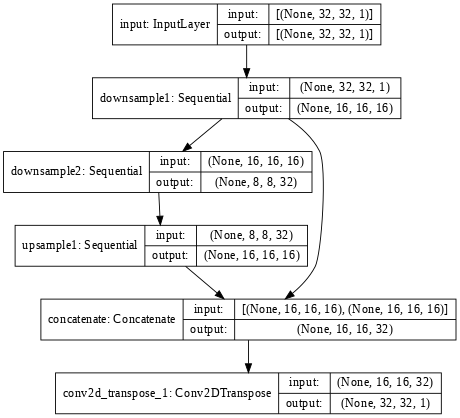

In [ ]:
generator = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
keras.utils.plot_model(generator, show_shapes=True, dpi=64)

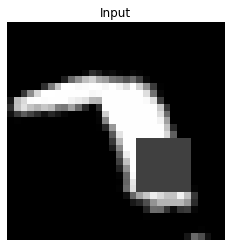

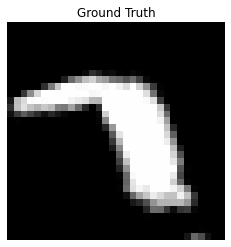

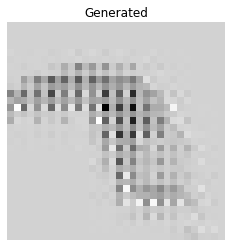

In [ ]:
# Testiranje Generatora
for x, y in tf_train.take(1):
  show_image(x[0], title='Input')
  show_image(y[0], title='Ground Truth')
  show_image(generator(x)[0], title='Generated')

In [ ]:
LAMBDA = 0

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target, alpha=1, loss_func=None):
  if loss_func is None:
    loss_func = bce

  # Kaznjava se Generator za svaku pogodjenu sliku diskriminatora
  gan_loss = loss_func(tf.ones_like(disc_generated_output), disc_generated_output)
  # Dodaje se L1 greska kako bi se forsiralo da slike izgledaju vise kao obicne
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  # 'alpha' parametar nam omogucava akcentovanja na neku od gresaka
  total_gen_loss = gan_loss + (alpha * l1_loss)
  return total_gen_loss, gan_loss, alpha * l1_loss

In [ ]:
def create_discriminator(input_size: int):
  """
  Diskriminator se sastoji iz niza "downsample" slojeva.
  Napomena: Diskriminator ocenjuje nekoliko ravnomerno rasporedjenih kvadrata na slici
    i za svaki govori da li je slika prava ili ne. 
  
  :param input_size: Dimenzija ulazne slike
  :return: Diskriminator
  """
  inputs = layers.Input(shape=[input_size, input_size, 1], name='disc_input')
  target = layers.Input(shape=[input_size, input_size, 1], name='disc_target')

  x = layers.concatenate([inputs, target])

  x = downsample(16, 4, apply_batchnorm=False)(x)
  x = downsample(32, 4)(x)
  x = layers.Conv2D(1, 5, strides=1)(x)
  x = layers.Conv2D(1, 4, strides=1)(x)

  return keras.Model(inputs=[inputs, target], outputs=x)

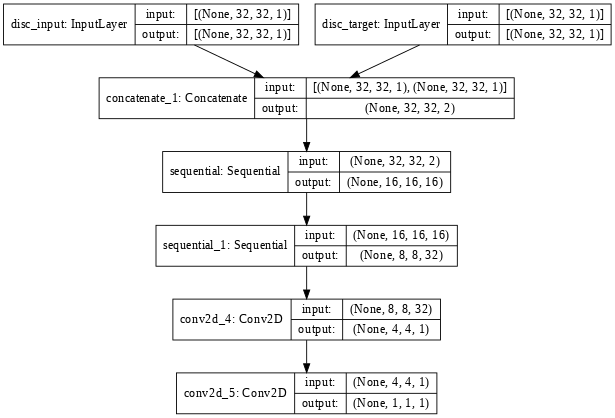

In [ ]:
discriminator = create_discriminator(input_size=IMG_SIZE)
keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
# Testiranje diskriminatora
result = None
for x, y in tf_train.take(1):
  result = discriminator([x, y])
result.shape

TensorShape([40, 1, 1, 1])

In [ ]:
def discriminator_loss(disc_generated_output, real_output, loss_func=None):
    if loss_func is None:
        loss_func = bce
    
    # Kaznjava se Diskriminator za svaku ne pogodjenu pravu sliku
    real_loss = loss_func(tf.ones_like(real_output), real_output)
    # Kaznjava se Diskriminator za svaku pogodjenu "laznu" sliku
    generated_loss = loss_func(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

In [ ]:
# Podesavanje optimizatora
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# Podesavanje parametara za periodicnog cuvanja stanja modela
checkpoint_dir = f'{MASTER_FOLDER}/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

In [ ]:
def test_image_generation(gen_model, input_batch, target_batch, img_size, rows=4):
    """
    Pomocna funkcija za vizualizaciju perfomansi modela.
    :param gen_model: Generator
    :param input_batch: Ulaz (slike sa postavljenim kvadratom)
    :param target_batch: Izlaz (prave slike)
    :param img_size: Dimenzija slike koja se prikazuje
    :param rows: Broj primera koji se prikazuju
    :return: None
    """
    assert rows <= input_batch.shape[0]
    prediction_batch = gen_model(input_batch, training=True)

    fig, axs = plt.subplots(figsize=(18, 3 * rows), ncols=3, nrows=rows)
    for i in range(rows):
        p_img = prediction_batch[i]
        i_img = input_batch[i]
        t_img = target_batch[i]
        for j, (img, title) in enumerate([(i_img, 'Input'), (t_img, 'Target'), (p_img, 'Prediction')]):
            axs[i][j].imshow(tf.reshape(img, shape=(img_size, img_size)), cmap='gray')
            axs[i][j].set_title(title)
            axs[i][j].axis('off')
    plt.show()

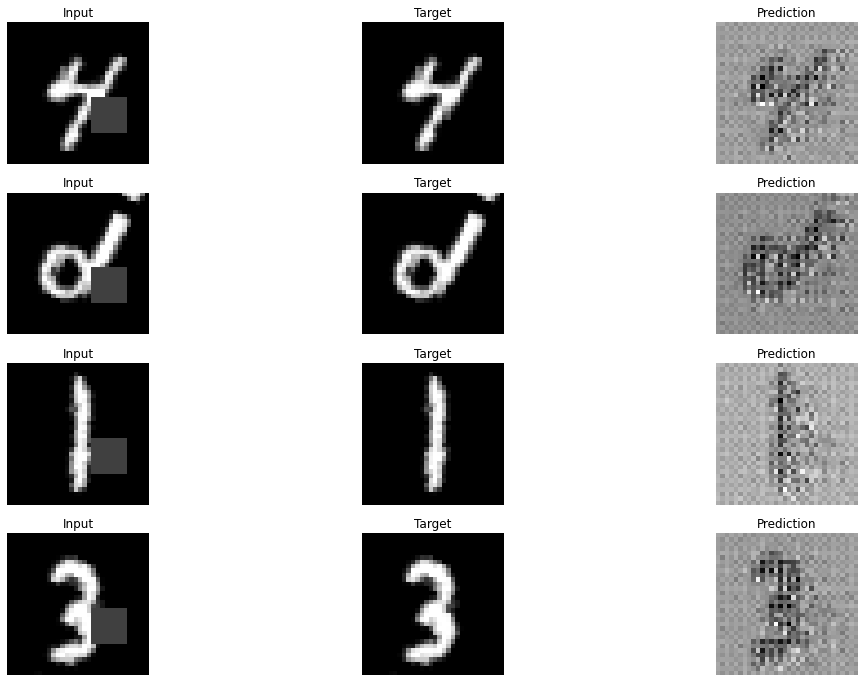

In [ ]:
# Testiranje funkcije "test_image_generation"
for x, y in tf_train.take(1):
  test_image_generation(generator, x, y, IMG_SIZE)

In [ ]:
# Podesavanje logovanja
summary_writer = tf.summary.create_file_writer(f'{MASTER_FOLDER}/logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [ ]:
class CGAN:
    def __init__(self,
                 generator,
                 discriminator,
                 alpha, 
                 generator_optimizer,
                 discriminator_optimizer,
                 summary_writer=None,
                 checkpoint=None,
                 checkpoint_prefix=None
                 ):
        """
        :param generator: Generator model
        :param discriminator: Diskriminator model
        :param alpha: Parametar za odnos izmedju GAN i L1 greske kod generator modela
        :param generator_optimizer: Optimizator za generator
        :param discriminator_optimizer: Optimizator za diskriminator
        :param summary_writer: Pomocni objekat za logovanje
        :param checkpoint: Pomocni objekat za cuvanje modela
        :param checkpoint_prefix: Putanja gde se cuva "checkpoint"
        """
        self.generator = generator
        self.discriminator = discriminator
        self.alpha = alpha
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.summary_writer = summary_writer
        self.checkpoint = checkpoint
        self.checkpoint_prefix = checkpoint_prefix
        if self.checkpoint_prefix is None:
            self.checkpoint_prefix = '.'

    @tf.function
    def train_step(self, input_image, target, step):
        """
        Za svaki korak ucenja se vrsi vise operacija:
        1. Generator generise izlaz na osnovu ulaza
        2. Diskriminator ocenjuje stvarne slike (da li su prave ili ne)
        3. Diskriminator ocenjuje generisane slike (da li su prave ili ne)
        4. Odredjuje se greska Generatora na osnovu ocene Diskriminatora (da li je prevara uspesna) iz koraka #3
          i na osnovu stvarne slike (L1 greska)
        5. Odredjuje se greska Diskriminatora na osnovu ocena iz koraka #2 i #3

        :param input_image: Ulaz generatora
        :param target: Prava slika
        :param step: Broj trenutnog koraka
        :return: Loss
        """
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # 1
            gen_output = self.generator(input_image, training=True)
            # 2
            disc_real_output = self.discriminator([input_image, target], training=True)
            # 3
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            # 4
            gen_total_loss, gen_gan_loss, gen_l1_loss = \
                generator_loss(disc_generated_output, gen_output, target, alpha=self.alpha)
            # 5
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss, self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_variables))

        if self.summary_writer is not None:
            with self.summary_writer.as_default():
                tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
                tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
                tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
                tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

        return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

    def eval_step(self, input_image, target):
        """
        Evaluira rezultate za dati ulaz
        :param input_image: Ulaz generatora
        :param target: Prava slika
        :return: Loss
        """
        gen_output = self.generator(input_image, training=True)
        disc_real_output = self.discriminator([input_image, target], training=True)
        disc_generated_output = self.discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = \
            generator_loss(disc_generated_output, gen_output, target, alpha=self.alpha)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

    def fit(self,
            train_ds,
            val_ds,
            steps,
            test_generation_period=1000,
            n_test_examples=4,
            img_size=32,
            checkpoint_period=5000):
        """
        Napomena: Namera je da se funkcija koristi u okviru IPython sveske

        Proces ucenja zasnovan na funkciji "train_step" koji dodatno:
        - prikazuje rezultate;
        - ispisuje stanje ucenja;
        - Kreira periodicno checkpoint.

        :param train_ds: Skup za treniranje
        :param val_ds: Skup za validaciju
        :param steps: Broj koraka treniranja
        :param test_generation_period: Broj koraka izmedju vizualizacije novih rezultata
        :param n_test_examples: Broj instanci koje se vizualizuju
        :param img_size: Dimenzija slike koja se prikazuje u primerima
        :param checkpoint_period: Period za cuvanje rezultata
        :return: Loss History
        """
        train_history, val_history = [], []
        dot_period = test_generation_period // 10

        example_input, example_target = next(iter(val_ds.take(n_test_examples)))
        start = time.time()

        for step, (input_image, target) in train_ds.repeat().take(steps+1).enumerate():
            if (step+1) % test_generation_period == 0:
                display.clear_output(wait=True)

                if step != 0:
                    print(f'Time taken for {step+1} steps: {time.time()-start:.2f} sec\n')

                start = time.time()

                test_image_generation(
                    self.generator, example_input, example_target, rows=n_test_examples, img_size=img_size)
                print(f"Step: {step+1}")

                for val_input_image, val_target in val_ds:
                    val_history.append(self.eval_step(val_input_image, val_target))

            train_history.append(self.train_step(input_image, target, step))

            # Training step
            if (step+1) % dot_period == 0:
                print('.', end='', flush=True)

            # Save (checkpoint) the model every 5k steps
            if self.checkpoint is not None and (step + 1) % checkpoint_period == 0:
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)

        return train_history, val_history

Time taken for 5000 steps: 61.08 sec



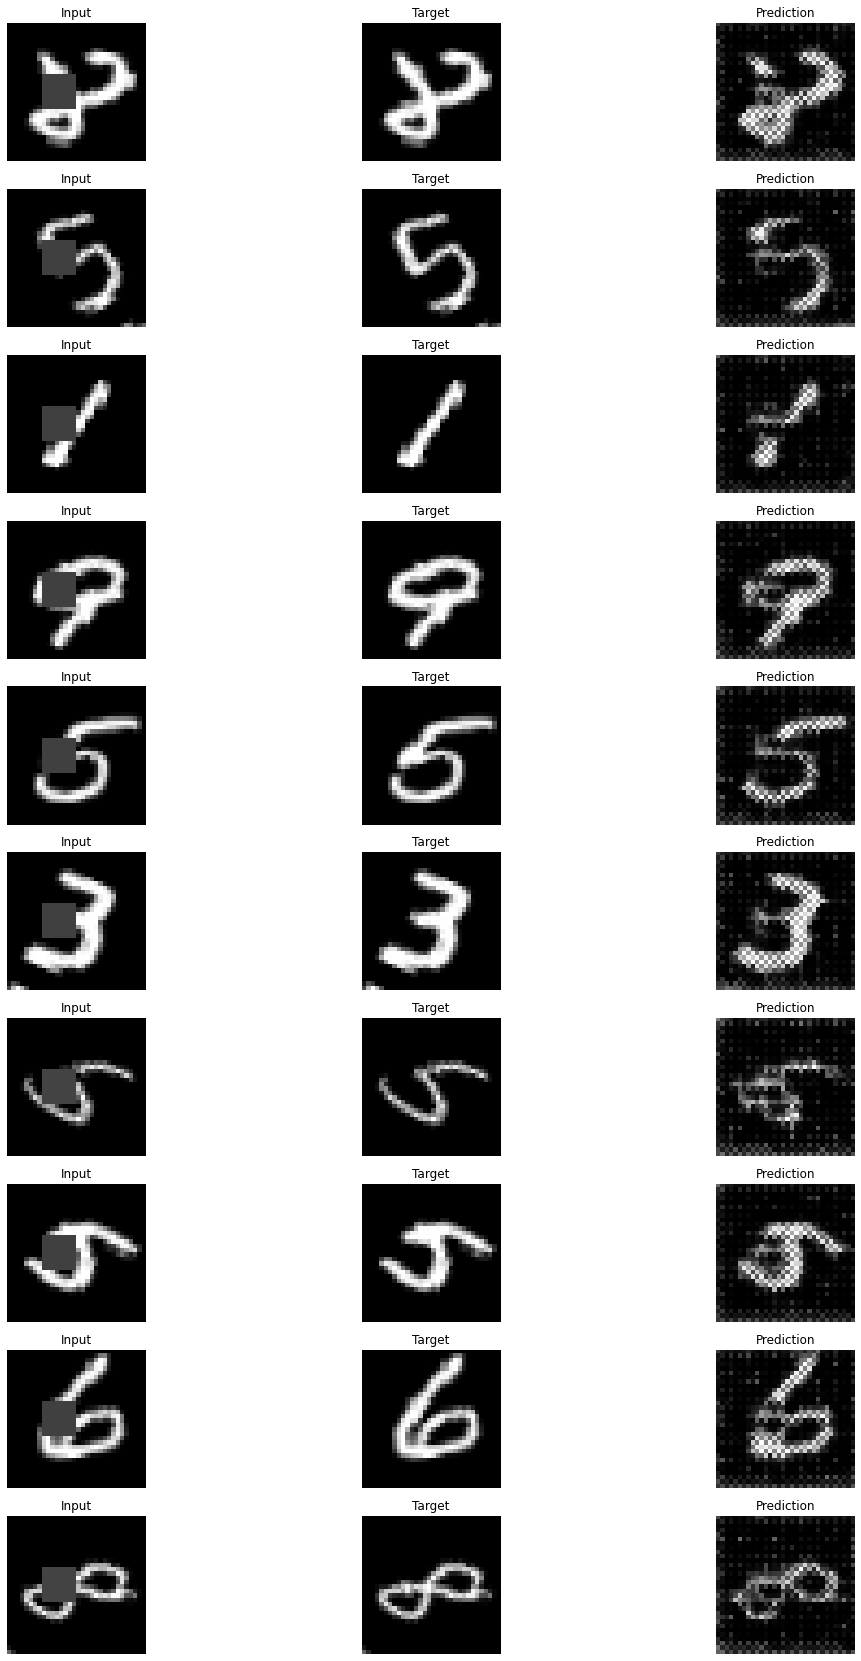

Step: 5000
.

In [ ]:
cgan = CGAN(
  generator=generator,
  discriminator=discriminator,
  alpha=1e-2,
  generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  summary_writer=summary_writer,
  checkpoint=checkpoint,
  checkpoint_prefix=checkpoint_prefix
)
train_history, val_history = cgan.fit(tf_train, tf_test, steps=5000, test_generation_period=1000, n_test_examples=10)

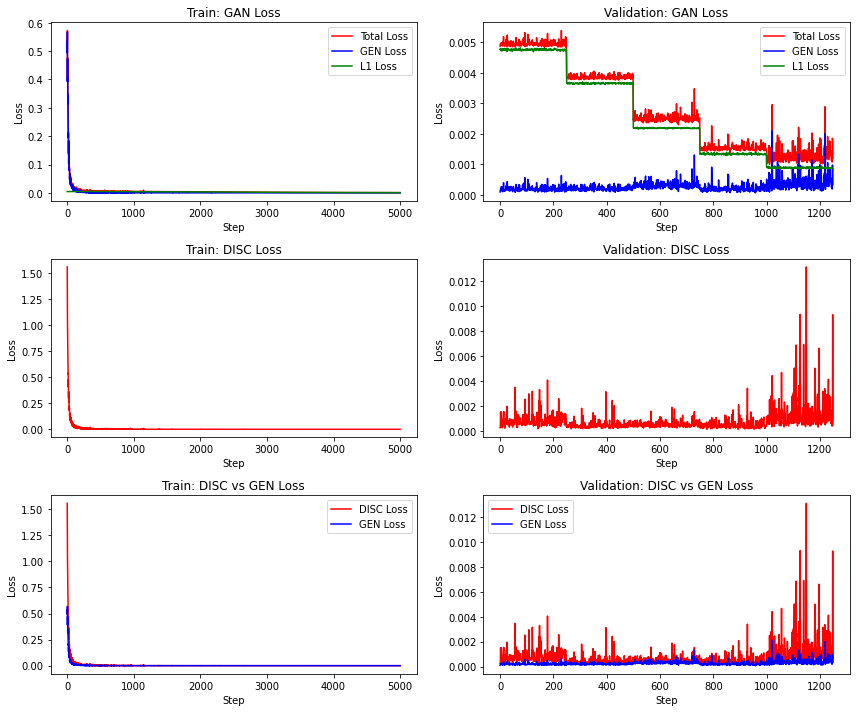

In [ ]:
# Prikazivanje rezultata na skupu za treniranje i validaciju/testiranje
def plot_history(history, axs, col, prefix=''):
  """
  :param history: Istorija funkcije greske
  :param axs: Grafice nad kojim se slika
  :param col: Kolona koja se popunjava (ako ima vise skupova, moze da se gleda uporedo rezultat)
  :param prefix: Prefiks za rezultat u izabranoj koloni
  """
  gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = zip(*history)
  axs[0][col].plot(gen_total_loss, color='red', label='Total Loss')
  axs[0][col].plot(gen_gan_loss, color='blue', label='GEN Loss')
  axs[0][col].plot(gen_l1_loss, color='green', label='L1 Loss')
  axs[0][col].set_title(f'{prefix} GAN Loss')
  axs[0][col].set_xlabel('Step')
  axs[0][col].set_ylabel('Loss')
  axs[0][col].legend()

  axs[1][col].plot(disc_loss, color='red')
  axs[1][col].set_title(f'{prefix} DISC Loss')
  axs[1][col].set_xlabel('Step')
  axs[1][col].set_ylabel('Loss')

  axs[2][col].plot(disc_loss, color='red', label='DISC Loss')
  axs[2][col].plot(gen_gan_loss, color='blue', label='GEN Loss')
  axs[2][col].set_title(f'{prefix} DISC vs GEN Loss')
  axs[2][col].set_xlabel('Step')
  axs[2][col].set_ylabel('Loss')
  axs[2][col].legend()

def plot_training_results(train_history, val_history):
  """
  Prikazuje grafike koji predstavljaju rezultate treniranja nad skupom za ucenje i nad skupom za validaciju.
  :param train_history: Istorija funkcije greske nad skupom za ucenje
  :param val_history: Istorija funkcije greske nad skupom za validaciju
  """
  fig, axs = plt.subplots(figsize=(12, 10), nrows=3, ncols=2)
  plot_history(train_history, axs, col=0, prefix='Train:')
  plot_history(val_history, axs, col=1, prefix='Validation:')
  plt.tight_layout()

plot_training_results(train_history, val_history)
plt.show()

In [ ]:
# Rezultat moze da se vizualizuje preko Tensorboard
# Napomena: Nakon uspesnog dostavljanja rezultata je neophodno da se ugasi celija
# !tensorboard dev upload --logdir "pix2pix/logs"

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/d2WKy41qQqSKDe2WeguBuQ",
    width="100%",
    height="1000px")